# IMDB Score Predictor

## Load the Dataframe

In [ ]:
import pandas as pd

In [ ]:
movies = pd.read_csv('../data/cleaned/indomovie-data.csv')

In [ ]:
movies.info()

In [ ]:
movies.shape

## Drop Unnecessary Columns

In [ ]:
movies.drop(columns=['url', 'title', 'description', 'year', 'imdb_votes', 'metascore', 'gross'], inplace=True)

## Remove Movies without IMDB Score

In [ ]:
movies.dropna(subset='imdb_score', inplace=True)

In [ ]:
movies.shape

In [ ]:
movies.info()

## Fill Null Values

In [ ]:
filler = {
    'director': 'No director',
    'stars': 'No actors',
    'runtime': 0,
    'genre': 'No genre',
    'rating': 'No rating',
}

movies.fillna(value=filler, inplace=True)

In [ ]:
movies.info()

In [ ]:
movies.head()

## Convert Runtime Values into Integer

In [ ]:
movies['runtime'] = movies['runtime'].astype('int64')

movies.dtypes

## Split Columns with Multiple Values

In [ ]:
splitted_rows = []

for index, row in movies.iterrows():
    directors = row['director'].split(', ')
    stars = row['stars'].split(', ')
    genres = row['genre'].split(', ')

    for director in directors:
        for star in stars:
            for genre in genres:
                splitted_row = {
                    'director': director,
                    'stars': star,
                    'genre': genre,
                    'runtime': row['runtime'],
                    'rating': row['rating'],
                    'imdb_score': row['imdb_score']
                }

                splitted_rows.append(splitted_row)

In [ ]:
splitted_movies = pd.DataFrame(splitted_rows)

splitted_movies.head()

In [ ]:
splitted_movies.info()

## Set the Features and the Label

In [ ]:
X = splitted_movies
y = X.pop('imdb_score')

## Set the Training and Test Dataset

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Transform Columns to become Feature Columns

In [47]:
import tensorflow as tf

In [ ]:
# from tensorflow.keras.layers import Input
# from tensorflow.keras.layers.experimental.preprocessing import StringLookup, CategoryEncoding, Normalization

In [48]:
CATEGORICAL_COLUMNS = [col for col in X_train.columns if col != 'runtime']
NUMERICAL_COLUMNS = ['runtime']

In [49]:
feature_columns = []

for feature in CATEGORICAL_COLUMNS:
    vocabulary = X_train[feature].unique()

    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature, vocabulary))

for feature in NUMERICAL_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature, dtype=tf.int64))

feature_columns

[VocabularyListCategoricalColumn(key='director', vocabulary_list=('Mike Wiluan', 'Alamsyah', 'Ifa Isfansyah', 'Riri Riza', 'Garin Nugroho', 'Hanny Saputra', 'Fajar Bustomi', 'Siti Nurul Anniza', 'Nia Di Nata', 'Awi Suryadi', 'Rizal Mantovani', 'Danial Rifki', 'Hestu Saputra', 'Ackyl Anwari', 'Liliek Sudjio', 'Benni Setiawan', 'Chiska Doppert', 'Jose Poernomo', 'Rako Prijanto', 'Nayato Fio Nuala', 'Roufy Nasution', 'No director', 'Andibachtiar Yusuf', 'Fajar Nugros', 'Muhammad Yusuf', 'Nurman Hakim', 'Pajri Andika', 'Ernest Prakasa', 'Shalahuddin Siregar', 'Wahyu Agung Prasetyo', 'Ismail Basbeth', 'Happy Salma', 'Charles Gozali', 'Sofyan Sharna', 'Joko Anwar', 'Tika Pramesti', 'Andi Fikri', 'Teddy Soeriaatmadja', 'Akil Wasa', 'Kan Lume', 'Indrayanto Kurniawan', 'Sentot Sahid', 'Eddie Cahyono', 'Rahabi Mandra', 'Azhar Kinoi Lubis', 'Pritagita Arianegara', 'Aria Kusumadewa', 'Monty Tiwa', 'Christ Helweldery', 'Bayu Skak', 'Yadi Sugandi', 'Dosy Omar', 'T.B. Silalahi', 'Conor Allyn', 'Teguh

In [ ]:
    # # Create a StringLookup layer
    # input_layer = Input(shape=(), dtype=tf.string)
    # embedding_layer = StringLookup(vocabulary=vocabulary)(input_layer)
    
    # # Create a CategoryEncoding layer
    # encoded_layer = CategoryEncoding(num_tokens=len(vocabulary))(embedding_layer)
    
    # feature_columns.append(encoded_layer)

    # # Handle numerical features using Normalization
    # input_layer = Input(shape=(1,), dtype=tf.int64)  # Change dtype to tf.int64
    # normalization_layer = Normalization()(input_layer)

    # # Append the normalization layer to the feature_columns list
    # feature_columns.append(normalization_layer)

## Make Input Functions

In [50]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():  # inner function, this will be returned
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
        
        if shuffle:
            ds = ds.shuffle(1000)  # randomize order of data
        
        ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
        
        return ds  # return a batch of the dataset
    
    return input_function  # return a function object for use

In [51]:
train_input_fn = make_input_fn(X_train, y_train)
test_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

## Create Linear Estimator

In [52]:
linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\LENOVO\\AppData\\Local\\Temp\\tmpbjnhcf_r', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training the Model

In [53]:
linear_est.train(train_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\LENOVO\AppData\Local\Temp\tmpbjnhcf_r\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 49.986877, step = 0
INFO:tensorflow:global_step/sec: 408.766
INFO:tensorflow:loss = 3.4435632, step = 100 (0.245 sec)
INFO:tensorflow:global_step/sec: 1266.79
INFO:tensorflow:loss = 1.7400652, step = 200 (0.079 sec)
INFO:tensorflow:global_step/sec: 1298.76
INFO:tensorflow:loss = 1.4202161, step = 300 (0.075 sec)
INFO:tensorflow:global_step/sec: 1305.7
INFO:tensorflow:loss = 1.1828481, step = 400 (0.079 sec)
INFO:tensorflow:global_step/sec: 1292.73
INFO:tensorflow:loss = 1.4219542, 

In [ ]:
# lin_reg = LinearRegression()

# lin_reg.fit(X_train,y_train)

## Evaluate the model

In [54]:
result = linear_est.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-08-28T17:45:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\LENOVO\AppData\Local\Temp\tmpbjnhcf_r\model.ckpt-4090
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.71157s
INFO:tensorflow:Finished evaluation at 2023-08-28-17:45:02
INFO:tensorflow:Saving dict for global step 4090: average_loss = 1.4294089, global_step = 4090, label/mean = 6.5359344, loss = 1.4373635, prediction/mean = 6.070253
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4090: C:\Users\LENOVO\AppData\Local\Temp\tmpbjnhcf_r\model.ckpt-4090


In [55]:
print(result['average_loss'])

1.4294089


## Visualize the Predictions by the Model

In [56]:
import matplotlib.pyplot as plt

In [57]:
pred_dicts = list(linear_est.predict(test_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\LENOVO\AppData\Local\Temp\tmpbjnhcf_r\model.ckpt-4090
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


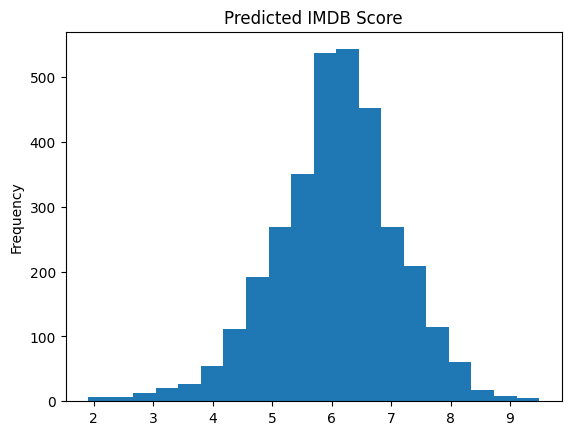

In [58]:
predicted_scores = [pred['predictions'][0] for pred in pred_dicts]

scores = pd.Series(predicted_scores)

scores.plot(kind='hist', bins=20, title='Predicted IMDB Score')

plt.show()

In [59]:
# import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [60]:
mse = mean_squared_error(y_test, scores)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 1.4294086840877953


In [61]:
r2 = r2_score(y_test, scores)

print("R-squared score (Coefficient of Determination):", r2)

R-squared score (Coefficient of Determination): 0.3886826844496476
